<a href="https://colab.research.google.com/github/aythsueh/Jrexile-Youtube-Data-API/blob/main/Jrexile_Youtube_Data_API_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Medium 文章標題


*   Python Project (1)- 使用 YouTube Data API v3 抓取頻道資訊+分析+視覺化 #1
*   Python Project (1)- 使用 YouTube Data API v3 頻道播放清單的影片資訊- 抓取 #2
*   Python Project (1)- 使用 YouTube Data API v3 影片統計數據- 準備 #3
*   Python Project (1)- 使用 YouTube Data API v3 影片統計數據- 分析+視覺化 #4

## Step 1. load packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import date
from datetime import datetime

import re

from google.colab import drive
drive.mount('/drive')

import argparse

from googleapiclient.discovery import build # API client library
from googleapiclient.errors import HttpError
DEVELOPER_KEY = '' # 之後公開要記得遮掉！！
youtube = build('youtube', 'v3', developerKey=DEVELOPER_KEY)
print(youtube)

## Step 2. retrive metadata from YouTube channels

In [ ]:
# create a list for storing channel IDs since there are 5 channels
channels_id_list = ['UCkQxM4lVLzkEk0HkSt90fYw',
                    'UCok6tjN84sl5FyGmoyD0_uA',
                    'UCdFlt1CdC04DUehXlkIxuSQ',
                    'UCOB1X12CH6XJpgzOXZ2jqMw',
                    'UCy0oOpw3qIA1q5OhsrywSSw']

# define a function for retrieving stats from multiple channels
def youtube_channels_stats(id_list):
  results = []

  # access data using YouTube API
  response = youtube.channels().list(part='id, snippet, contentDetails, statistics',
                                     fields='items(id, snippet(title, description, publishedAt), contentDetails(relatedPlaylists), statistics(viewCount, subscriberCount, videoCount))',
                                     id=','.join(id_list)).execute()

  # put the results into a dict, then convert to a data frame
  for channel in response['items']:
    temp_data = dict(channel_id = channel['id'],
                     channel_name = channel['snippet']['title'],
                     published_date = channel['snippet']['publishedAt'],
                     playlist_id = channel['contentDetails']['relatedPlaylists']['uploads'],
                     views = channel['statistics']['viewCount'],
                     subscribers = channel['statistics']['subscriberCount'],
                     videos = channel['statistics']['videoCount'])
    results.append(temp_data)

  return results


# call the function with a channel ID list
channels_df = pd.DataFrame(youtube_channels_stats(channels_id_list))
print(channels_df)

# export as a csv file
channels_df.to_csv('/drive/My Drive/DataAnalysis_Python_Projects/JrEXILE/youtube/channels_raw.csv', index=False)

                 channel_id                     channel_name  \
0  UCy0oOpw3qIA1q5OhsrywSSw   PSYCHIC FEVER from EXILE TRIBE   
1  UCOB1X12CH6XJpgzOXZ2jqMw  BALLISTIK BOYZ from EXILE TRIBE   
2  UCkQxM4lVLzkEk0HkSt90fYw     GENERATIONS from EXILE TRIBE   
3  UCok6tjN84sl5FyGmoyD0_uA     THE RAMPAGE from EXILE TRIBE   
4  UCdFlt1CdC04DUehXlkIxuSQ      FANTASTICS from EXILE TRIBE   

                published_date               playlist_id      views  \
0  2021-07-02T04:33:10.105521Z  UUy0oOpw3qIA1q5OhsrywSSw   18480321   
1         2019-09-10T03:04:24Z  UUOB1X12CH6XJpgzOXZ2jqMw   47361825   
2         2013-05-29T01:21:50Z  UUkQxM4lVLzkEk0HkSt90fYw  141635523   
3         2019-09-26T06:02:37Z  UUok6tjN84sl5FyGmoyD0_uA  169087237   
4         2019-09-26T06:03:12Z  UUdFlt1CdC04DUehXlkIxuSQ   81696745   

  subscribers videos  
0       72200    291  
1      131000     51  
2      347000    160  
3      310000     64  
4      206000     91  


## Step 3. process Channel data, and manually add a bit infomation from LDH website and/or wikipedia

In [ ]:
processing_df = channels_df.copy()

# 1. shorten & lowercase groups' names
processing_df['channel_name'] = processing_df['channel_name'].apply(lambda x: re.sub(r'\sfrom EXILE TRIBE', '', x)).str.lower()
# sort the channels by debut date
sort_order = ['generations', 'the rampage', 'fantastics', 'ballistik boyz', 'psychic fever']
processing_df.index = pd.CategoricalIndex(processing_df['channel_name'], categories=sort_order)
processing_df.sort_index(inplace=True)


# 2. look up for debut date, and then calculate days after their debut
# manually input the debut dates
processing_df['debutDate'] = [date(2012,11,21), date(2017,1,25), date(2018,12,5), date(2019,5,22), date(2022,7,13)]
# today's date
today = datetime.today().date()
# calculate the days after debut
processing_df = processing_df.assign(timeAfterDebut = lambda x: (today - x.debutDate).dt.days)


# 3. convert data type to integer
processing_df[['views', 'subscribers', 'videos']] = processing_df[['views', 'subscribers', 'videos']].apply(lambda x: x.astype(int))


# 4. change the unit to in million
processing_df = processing_df.assign(views_million = lambda x: round(x.views/1000000, 2))


# 5. calculate average video views for each group
processing_df = processing_df.assign(meanView_million = lambda x: round(x.views_million/x.videos, 2))


# 6. calculate average days they uploaded a video
channels_df_cleaned = processing_df.assign(meanVideoDays = lambda x: round(x.timeAfterDebut/x.videos, 2))


print(channels_df_cleaned)
# export as a csv file
channels_df_cleaned.to_csv('/drive/My Drive/DataAnalysis_Python_Projects/JrEXILE/youtube/channels_cleaned.csv', index=False)

                              channel_id    channel_name  \
channel_name                                               
generations     UCkQxM4lVLzkEk0HkSt90fYw     generations   
the rampage     UCok6tjN84sl5FyGmoyD0_uA     the rampage   
fantastics      UCdFlt1CdC04DUehXlkIxuSQ      fantastics   
ballistik boyz  UCOB1X12CH6XJpgzOXZ2jqMw  ballistik boyz   
psychic fever   UCy0oOpw3qIA1q5OhsrywSSw   psychic fever   

                             published_date               playlist_id  \
channel_name                                                            
generations            2013-05-29T01:21:50Z  UUkQxM4lVLzkEk0HkSt90fYw   
the rampage            2019-09-26T06:02:37Z  UUok6tjN84sl5FyGmoyD0_uA   
fantastics             2019-09-26T06:03:12Z  UUdFlt1CdC04DUehXlkIxuSQ   
ballistik boyz         2019-09-10T03:04:24Z  UUOB1X12CH6XJpgzOXZ2jqMw   
psychic fever   2021-07-02T04:33:10.105521Z  UUy0oOpw3qIA1q5OhsrywSSw   

                    views  subscribers  videos   debutDate  timeAft

In [ ]:
print(channels_df_cleaned.iloc[:, -5:])

                 debutDate  timeAfterDebut  views_million  meanView_million  \
channel_name                                                                  
generations     2012-11-21            3868         141.64              0.89   
the rampage     2017-01-25            2342         169.09              2.64   
fantastics      2018-12-05            1663          81.70              0.90   
ballistik boyz  2019-05-22            1495          47.36              0.93   
psychic fever   2022-07-13             347          18.48              0.06   

                meanVideoDays  
channel_name                   
generations             24.18  
the rampage             36.59  
fantastics              18.27  
ballistik boyz          29.31  
psychic fever            1.19  


## Step 4. analysis + plots-> conclusion + next step

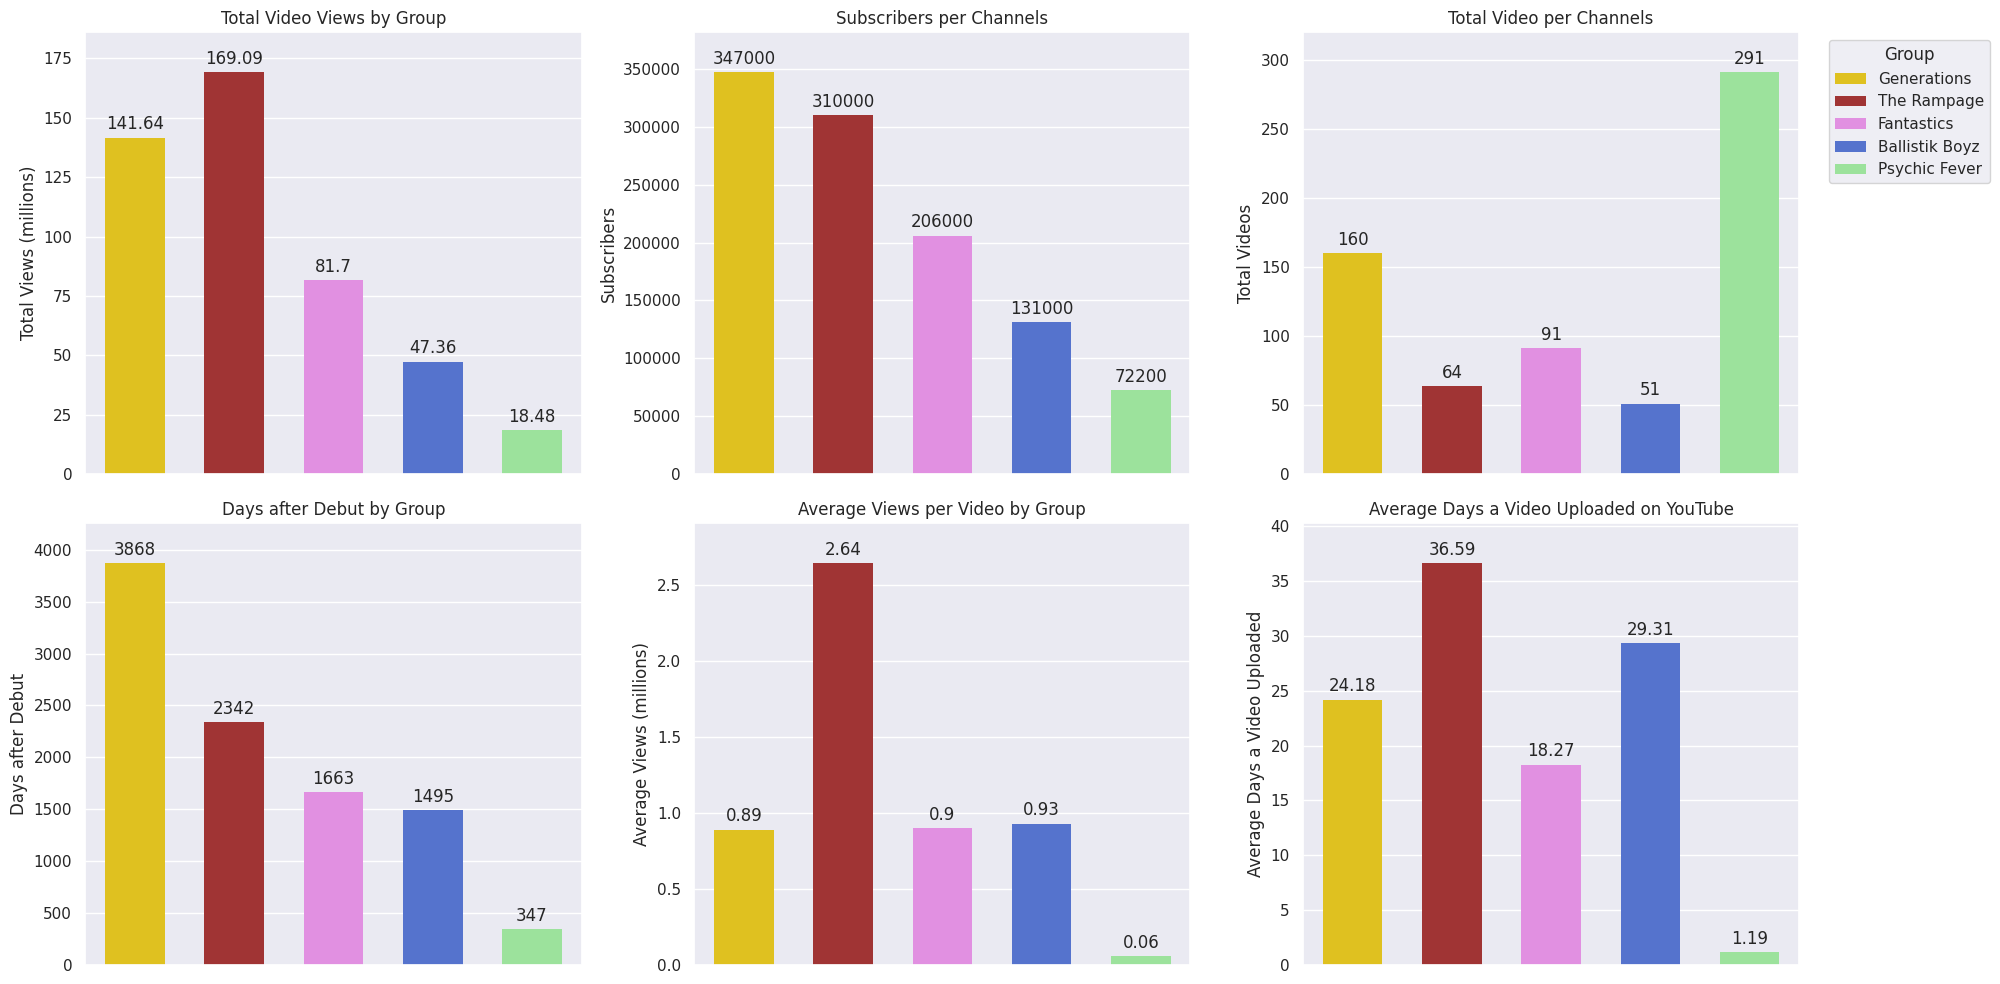

In [ ]:
sns.set_theme(palette='Set2')
fig, ax = plt.subplots(2, 3, figsize=(20,10))

palette={'generations': 'gold',
         'the rampage': 'firebrick',
         'fantastics': 'violet',
         'ballistik boyz': 'royalblue',
         'psychic fever': 'lightgreen'}
group_name = ['Generations', 'The Rampage', 'Fantastics', 'Ballistik Boyz', 'Psychic Fever']

def channelStats_barplot(data, ax, y, ylabel, title):
  sns.barplot(data=data, ax=ax, x='channel_name', y=y,
              width=0.6, linewidth=0, palette=palette, label=group_name)
  ax.set_title(title)
  ax.set_xlabel('')
  ax.set_ylabel(ylabel)
  for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=3)
  ax.margins(y=0.1)
  ax.set_xticks([])


channelStats_barplot(channels_df_cleaned,
                     ax[0,0],
                     'views_million',
                     'Total Views (millions)',
                     'Total Video Views by Group')
channelStats_barplot(channels_df_cleaned, ax[0,1], 'subscribers', 'Subscribers', 'Subscribers per Channels')
channelStats_barplot(channels_df_cleaned, ax[0,2], 'videos', 'Total Videos', 'Total Video per Channels')
channelStats_barplot(channels_df_cleaned, ax[1,0], 'timeAfterDebut', 'Days after Debut', 'Days after Debut by Group')
channelStats_barplot(channels_df_cleaned, ax[1,1], 'meanView_million', 'Average Views (millions)', 'Average Views per Video by Group')
channelStats_barplot(channels_df_cleaned, ax[1,2], 'meanVideoDays', 'Average Days a Video Uploaded', 'Average Days a Video Uploaded on YouTube')

ax[0,2].legend(loc='upper right', bbox_to_anchor=(1.4,1), title='Group')

plt.tight_layout()
plt.show()

## 討論:
*   左下第一張圖的出道天數：依序是 Generations、The Rampage、Fantastics、Ballistik Boyz、Psychic Fever。
*   左上第一張圖的頻道的觀看次數： The Rampage 頻道擁有最多的觀看次數，接著是 Generations、Fantastics、Ballistik Boyz、Psychic Fever。
*   中上的第二張圖的頻道的訂閱人數：隨著團體的出道時間越久，頻道的訂閱者數量越多。
*   右上的第三張圖的上傳至頻道的公開影片數量：出道最久的 Generations 上傳約 160 部影片，接著是 Fantastics、 The Rampage， Ballistik Boyz 最少，僅有 51 支影片。Psychic Fever 出道不到一年，發佈最多的影片。
*   中下的第二張圖的每一支影片的平均觀看次數：The Rampage 平均每部影片有 263 萬的觀看次數，是次高團體的兩倍多。 Fantastics 有第二高的平均觀看次數，每支影片約有 93 萬次的觀看次數。接著是 Ballistik Boyz，平均觀看次數為 91 萬次。Generations 的平均觀看次數為 88 萬。 Psychic Fever 平均觀看次數為 6 萬。
*   右下的第三張圖是平均多久上傳一支影片：Psychic Fever 最多產，平均一天多一點就上傳一支影片。Fantastics 其次，平均兩三個禮拜上傳影片。接著是 Generations 的 24 天。Ballistik Boyz 一個月一支影片。The Rampage 最不頻繁。

根據 YouTube 頻道數據，看起來 The Rampage 是 Jr.EXILE 在音樂相關影片方面，人氣最高的團體。

## 小結:
*   總結來說，The Rampage 上傳到 YouTube 頻道的影片獲得最多的總觀看次數，但也間隔較久才上傳新的影片，影片數量相對少。連頻道訂閱人數數量（31 萬）快追上出道最久的 * Generations（34.7 萬）。可以說，從 YouTube 上的頻道統計數據來看，The Rampage 是 Jr. EXILE 裡面最有人氣的組合。
*   Fantastics 的總觀看次數、頻道訂閱人數數量、影片數量、出道時間皆居中。看起來表現穩定。
*   Generations 出道時間是其他團體的兩三倍，觀看次數、頻道訂閱人數數量、影片數量都是最多或次多。很穩的十年團體。
*   Ballistik Boyz 出道四年，看起來不常上傳新影片，影片數最少，雖然頻道觀看次數跟頻道訂閱人數數量皆為第二少，但平均觀看次數追上 Generations 跟 Fantastics。看起來相當有發展潛力，可能需要多一點作品。
*   Psychic Fever 發佈最多的影片，頻道訂閱人數跟頻道觀看數量皆最少。然而，是出道不到一年的新團，也許需要多表演多多宣傳。

以上是針對 YouTube channel 的分析，針對專案目標目前依然處在非常粗略的分析報告。🙇🏻‍♀️

## Caveats:
1.   頻道的觀看次數（views）似乎計入了影片、直播（livestream）跟 shorts，且我無法確定是否計入不公開影片的觀看次數（據說是沒有）。舉例來說，FANTASTICS 的頻道觀看次數（8千萬次）超過我後來抓取他們每一個公開影片的總觀看次數（7千萬次）。
2.   因為頻道的 views 的計數不明，因此無法計算真正的單支影片平均觀看次數。但現在計算的 Average Views per Video by Group （viewCount/videoCount）還是有一定的參考價值。
3.   YouTube API 給的 videoCount（上傳至頻道的公開影片數量）只計入影片，然而，直播跟 shorts 也是重要的 YouTube 宣傳或互動活動，卻沒辦法獲取相關數據。
4.   也因此無法由「平均多久上傳一支公開影片到 YouTube 頻道」去衡量團體的 productivity。
5.   出道日跟頻道加入 YouTube 的日期差異不小。若要計算「平均多久上傳一支影片到 YouTube 頻道」應該要使用頻道加入日期。但 productivity 或活躍期間應該從出道日開始計算。
6.   有些音樂影片是由唱片公司上傳到 YouTube 上，未能列入團體各頻道觀看次數的計算。可以使用 youtube.search().list() 搭配選用參數（e.g., type, order etc.）去抓 video ID ，再抓影片統計數據
7.   YouTube 頻道資料並未區分不同種類的影片類型，因此，每個團體的特性（i.e., 歌唱實力、舞蹈實力、現場表演能力、綜藝表演等等）未能從頻道統計數據得知。